# I am something of a painter myself Project

DCGAN utilises Convolutional and Transposed Convolutional layers, which it strategically embeds into a GAN architecture. Convolutions are a way to extract meaningful information from your data. They work particularly well with images allowing the network to learn the key features efficiently. Transposed Convolutions also use filters to process the data, but their goal is the opposite of a regular Convolution. We use them to upsample the data to a larger output feature map.

In this project, we will create four different models :
- 1 Generator model that will allow to convert Monet paintings to fake photos
- 1 Generator model that will allow to convert photos to fake Monet style paintings
- 1 Discriminator model that will differenciate fake Monet paintings from real ones
- 1 Discriminator model that will differenciate fake photos from real ones.  

We will start with EDA, then put together the four different models as a single DCGAN model, fit it and test the generator loss and discriminator loss to improve the outputs of both generators.  

I mainly used the online console from Kaggle to run this project, their faster processing and available datasets helped a lot. I used the data available <a href="https://www.kaggle.com/competitions/gan-getting-started/data">here</a>.   

Most of the code I used is inspired from Atul Rajan's <a href="https://python.plainenglish.io/cycle-gans-generating-paintings-of-my-campus-in-van-goghs-style-9d578b11edf6">Cycle GANs: Generating Paintings of My Campus in Van Gogh’s Painting Style</a> who himself based his Deep Learning algorithm on the <a href="https://arxiv.org/pdf/1703.10593v7.pdf">Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks</a> paper from Phillip Isola, Jun-Yan Zhu, Tinghui Zhou and Alexei A. Efros.

In [1]:
# import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras # for building Neural Networks
from tensorflow.keras import layers
from keras.models import Sequential # for assembling a Neural Network model
from keras.layers import Input,Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from tensorflow.keras.optimizers import Adam # for model optimization 
import tensorflow_addons as tfa

# Data manipulation
import numpy as np # for data manipulation
import sklearn
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator

# Visualization
import cv2 # for ingesting images
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
import graphviz # for showing model diagram
from IPython.display import display, clear_output
from PIL import Image

# Other utilities
import sys
import os
import random
import time
import shutil
import re

main_dir=os.path.dirname(sys.path[0])


## Setting up the data

To train the GAN, I used the <em>Monet2Photo</em> TensorFlow dataset of Monet paintings and pictures. This dataset was already available on Kaggle and corresponds to the paintings and photos used in the "I am something of a painter myself" competition. Importing them as a Tensorflow dataset allows for the data to already be split in testing and training subsets, as well as already having labels to help evaluate loss. 

The red messages signal that I did not link a Google Cloud Platform and adjustments in the GPU Numa nodes type but they do not prevent the cell from accomplishing its task.

In [2]:
dataset, metadata = tfds.load("cycle_gan/monet2photo",
    with_info=True, as_supervised=True)
train_monet, train_photo = dataset["trainA"], dataset["trainB"]
test_monet, test_photo = dataset["testA"], dataset["testB"]

2022-09-22 16:16:24.154335: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1072 [00:00<?, ? examples/s]

Shuffling cycle_gan-trainA.tfrecord...:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating trainB examples...:   0%|          | 0/6287 [00:00<?, ? examples/s]

Shuffling cycle_gan-trainB.tfrecord...:   0%|          | 0/6287 [00:00<?, ? examples/s]

Generating testA examples...:   0%|          | 0/121 [00:00<?, ? examples/s]

Shuffling cycle_gan-testA.tfrecord...:   0%|          | 0/121 [00:00<?, ? examples/s]

Generating testB examples...:   0%|          | 0/751 [00:00<?, ? examples/s]

Shuffling cycle_gan-testB.tfrecord...:   0%|          | 0/751 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


2022-09-22 16:16:37.308395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 16:16:37.408143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 16:16:37.408991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 16:16:37.411308: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

This next cell defines functions to preprocess images so that they are ready to go through the DCGAN model. As described in the paper on Cycle GANs, the model performed best when a random crop, jitter, and mirror was applied to the dataset :
- the <b>normalize</b> function changes the RGB value range of the images from [0, 255] to [-1, 1] so that they can be used with the tanh activation function that centers around 0 and ranges from -1 to 1. This speeds up learning and leads to faster convergence.
- the <b>random_jitter</b> function upsizes the images to 286x286x3 using the Nearest Neighbor method to then randomly crop and flip the images. Cropping helps our model generalize better because the objects of interest we want our models to learn are not always wholly visible in the image or the same scale in our training data.
- <b>preprocess_image_train</b> and <b>preprocess_image_test</b> apply those functions to the train and test datasets.

In [3]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

### Initializing some important values
BUFFER_SIZE = 1000
BATCH_SIZE = 6
IMG_WIDTH = 256
IMG_HEIGHT = 256

### Randomly crop the image
def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

### Normalize the image
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

### Random jitter in the image according to the paper
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)
        # random mirroring
    image = tf.image.random_flip_left_right(image)
    return image

### Preprocessing the image
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image, label):
    image = normalize(image)
    return image

The <b>tf.data.Dataset.map</b> function allows to apply transformations to prepare the data for the model.  
The <b>tf.data.Dataset.cache</b> transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each iteration of the model. However, this cache method is limited by the size of your memory and therefore limits the batch size. With the computational power and memory offered by Kaggle, I was limited to selecting BATCH_SIZE=6.  
<b>tf.data.Dataset.shuffle</b> randomly selects  as given number of images set by BUFFER_SIZE. In our case, BUFFER_SIZE=1000. We then use <b>tf.data.Dataset.batch</b> to select a given number of images from that buffer set by BATCH_SIZE=6.

In [4]:
train_monet = train_monet.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
train_photo = train_photo.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
test_monet = test_monet.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

Here we can see examples of a Monet painting and a photo contained in the training sets.

2022-09-22 16:16:40.858892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-22 16:16:44.446184: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-22 16:16:48.033052: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` inste

(-0.5, 255.5, 255.5, -0.5)

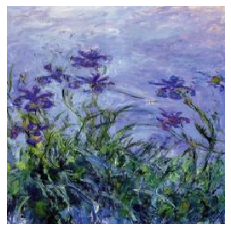

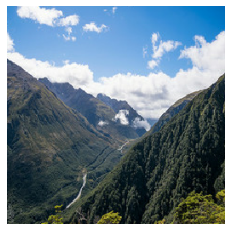

In [5]:
sample_monet = next(iter(train_monet))
sample_photo = next(iter(train_photo))
plt.figure()
plt.imshow(sample_monet[0] * 0.5 + 0.5)
plt.axis(False)
plt.figure()
plt.imshow(sample_photo[0]*0.5 + 0.5)
plt.axis(False)

## Creating the generator model

In the cells that follow, we will create the Generator model necessary for implementing our DCGAN model. For the generators, the authors of the paper used a Resnet architecture with 6 or 9 residual blocks followed by 2 Conv2DTranspose layers. Additionally, they used Instance Normalization instead of Batch Normalization.  

<b>Normalization</b> or feature scaling is a way to make sure that features with very diverse ranges will proportionally impact the network performance. Without normalization, some features or variables might be ignored. Instance Normalization transforms a single training sample by calculating the mean and variance of each sample and normalizing each spatial dimension.  
Batch Normalization operates in the same way with a mini-batch of samples. This makes Batch Normalization dependent on the batch size in that, to obtain a statistically more accurate mean and variance, the batch size needs to be large. When we have a limitation on the memory, we’ll have to opt for smaller batch sizes which can be problematic in some cases. In our case, we have a small batch size setting so Instance Normalization will perform better than Batch Normalization.  

The <b>padding</b> in the model allows to add 2 rows on each side as well as 2 colums on top and bottom. The convolutional layer can then start its filtering from the most outer pixel of the image instead of starting from the second row and finishing on the penultimate row and outputing a smaller feature map which is called border effect. Border effect is often not a problem for large images and small filters but can be a problem with small images. It can also become a problem once a number of convolutional layers are stacked.

The <b>ReLu</b> activation function in the model is a simple and fast method for implementing nonlinear functions. The name “rectified linear unit” or “relu” comes from the fact that it is always positive and zero when negative, which makes it very easy to implement in computer code. ReLU is non-linear, which means it does not have any backpropagation errors. Compared to sigmoid functions, models based on ReLUs are easy and quick to build for larger networks.

The <b>tanh</b> activation function is used as the last layer of the generator model. The tanh function is a shifted and stretched version of the sigmoid activation function with a greater gradient as its output range is [-1, 1]. Therefore, using the tanh activation function results in higher values of gradient during training and higher updates in the weights of the network. Also, the output of tanh is symmetric around zero leading to faster convergence.

In [6]:
## Making the functions
def _get_norm_layer(norm):
    if norm == "none":
        return lambda: lambda x: x
    elif norm == "batch_norm":
        return keras.layers.BatchNormalization
    elif norm == "instance_norm":
        return tfa.layers.InstanceNormalization
    elif norm == "layer_norm":
        return keras.layers.LayerNormalization

In [7]:
### Making the resnet block
def ResnetGenerator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = _get_norm_layer(norm)
    def _residual_block(x):
        dim = x.shape[-1]
        h = x
    
        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)
        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        return keras.layers.add([x, h])
# 0
    h = inputs = keras.Input(shape=input_shape)
# 1
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)
# 2
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)
# 3
    for _ in range(n_blocks):
        h = _residual_block(h)
# 4
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)
# 5
        h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
        h = tf.tanh(h)
    return keras.Model(inputs=inputs, outputs=h)

## Creating the discriminator model

In the cells that follow, we will create the Discriminator model necessary for implementing our DCGAN model. The discriminator model for Cycle GAN according to the paper is a Patch GAN. A typical classification net would output a 0 or 1 when it gets an image as an input. A patch GAN outputs a grid of values instead. For instance, a 3 by 3 grid could be output instead of a one by one. Each of these values is in the range [0, 1]. If we can see a single value in this grid, it corresponds to seeing a patch in the image.
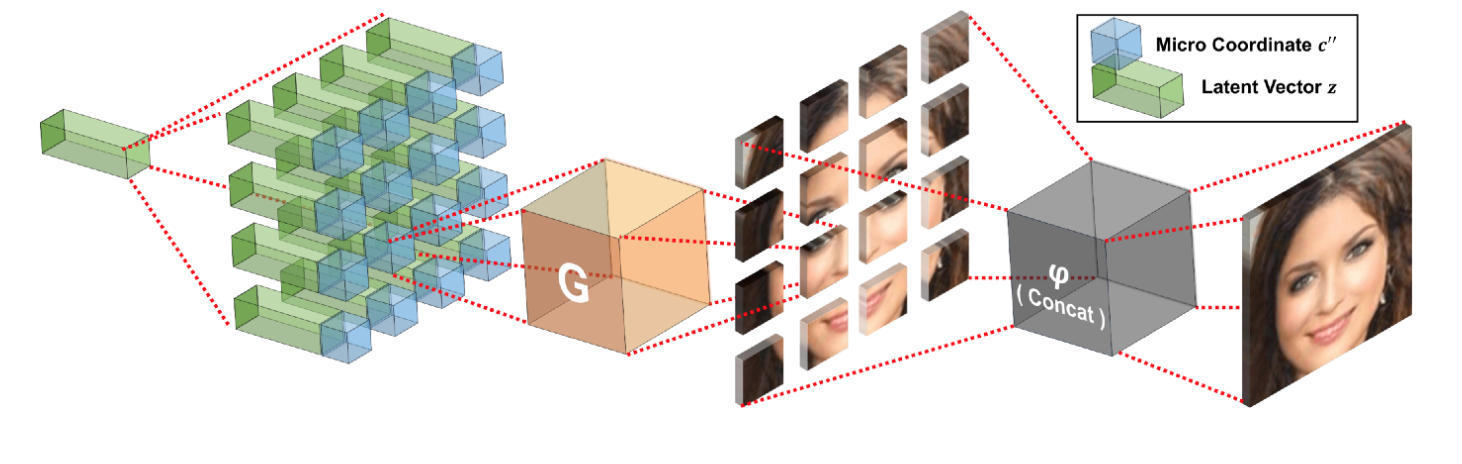

<b>Leaky ReLU</b> is a type of activation function that helps to prevent the function from becoming saturated at 0. Leaky ReLU is a modification of the ReLU activation function. It has the same form as the ReLU, but it will leak some positive values to 0 if they are close enough to zero.

In [8]:
def ConvDiscriminator(input_shape=(256, 256, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):
    dim_ = dim
    Norm = _get_norm_layer(norm)
# 0
    h = inputs = keras.Input(shape=input_shape)
# 1
    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same')(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)
    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)
# 2
    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)
# 3
    h = keras.layers.Conv2D(1, 4, strides=1, padding='same')(h)
    return keras.Model(inputs=inputs, outputs=h)

## Initializing the models

As stated before, our DCGAN has two generators and two discriminators. <b>Generator_g</b> will take in a Monet painting as an input and will output a photo. The <b>generator_f</b> will take in a Monet painting and generate a photo.  
<b>Discriminator_x</b> will take a photo as input and will decide wether it is real or fake while <b>discriminator y</b> will take a painting as an input and decide wether it is real or fake.

In [9]:
## OUTPUT_CHANNELS = 3 ## Hardcoded in the functions
## Building the Resnet Generator as per the cycle gan paper
generator_g = ResnetGenerator()
generator_f = ResnetGenerator()
## Building the Discriminator as per the cycle gan paper
discriminator_x = ConvDiscriminator()
discriminator_y = ConvDiscriminator()

In [10]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf.compat.v1.pad (TFOpLambda)   (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        tf.compat.v1.pad[0][0]           
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
tf.nn.leaky_relu (TFOpLambda (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 64, 128)       131072    
_________________________________________________________________
instance_normalization_46 (I (None, 64, 64, 128)       256       
_________________________________________________________________
tf.nn.leaky_relu_1 (TFOpLamb (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 256)       5242

As of now, if we try to generate photos or paintings, the outputs are totally random and inaccurate as seen below.

2022-09-22 16:16:53.292994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


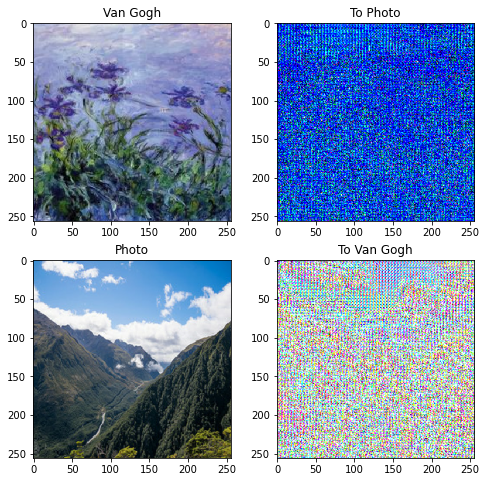

In [12]:
to_photo = generator_g(sample_monet)
to_monet = generator_f(sample_photo)
## Plot the sample 
plt.figure(figsize = (8, 8))
contrast = 8
imgs = [sample_monet, to_photo, sample_photo, to_monet]
title = ["Monet", "To Photo", "Photo", "To Monet"]
for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [13]:
LAMBDA = 100
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### Setting the optimizer

Optimizers are the expanded class, which includes the method to train your learning model. Choosing the right optimizer is necessary for your model as it improves training speed and performance. For this model, we will be using the Adam Optimizer. Adam stands for adaptive moment estimation, which is another way of using past gradients to calculate current gradients. Adam utilizes the concept of momentum by adding fractions of previous gradients to the current one. In ordr for it to work well, we set its parameters as follows :
- <b>alpha</b> : also referred to as the learning rate or step size. It represents the proportion with which weights are updated (e.g. 0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated but the end result doesn't get really precise. Smaller values (e.g. 1.0E-5) slow learning right down during training but allow for a better end fit. We will set the learning rate to 0,0002 as stated in the paper.
- <b>beta_1</b> : it represents the exponential decay rate for the first moment estimates. We will set beta_1 to 0,5 as stated in the paper.

In [14]:
### Initializing the loss functions:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

The <b>generate_images</b> function will be used to output a given photo and painting with its generated counterpart to visualize the progress of the DCGAN model throughtout the training.

In [15]:
def generate_images(model1,model2, test_input1, test_input2):
    prediction1 = model1(test_input1) 
    prediction2 = model2(test_input2)
    plt.figure(figsize=(9, 9))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Painting', 'Predicted Photo','Input Photo', 'Predicted Painting',]
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Setting the training step

The training step is hey to the functioning of our model. As input, it takes in a real Monet painting and a real photo. It will then generate six different images :
- two fake photos with a real Monet painting as input (fake photo and same fake photo)
- two fake paintings with a real photo as input (fake painting and same fake painting)
- a fake painting with a real Monet painting as input (cycle painting)
- a fake photo with a real photo as input (cycle photo)

It will then test each discriminator with the fake and real painting for discriminator_x and the fake and real photo for discriminator_y. It can now calculate the <b>loss of each generator</b> using the output of the discriminators.  
The <b>total cycle loss</b> is also computed by adding the cycle loss of generator_g (loss between real painting and cycle painting) to the cycle loss of generator_f (loss between real photo and cycle photo).  
The <b>total generator loss</b> is then calculated. It is the sum of the loss, the total cycle loss and the identity loss. Identity loss can be calculated by comparing the differences between two images that were generated by the same input.
Finally, the <b>discriminator loss</b> is calculated by comparing the output of each discriminator when they have a real image vs a fake image as input.

The new gradients for each generator and each discriminator are then calculated with the <b>tape.gradient</b> function and are applied to the optimizers.



In [16]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
# same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
# calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
# Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

        # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
# Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

This cell initializes <strong>tf.train.Checkpoint</strong> that allows to save checkpoints of the generator_f model. That would allow us to access different states of development of the model to see what kind of paintings were generated at a certain point in training. It can be useful if you realize that you overfitted your model and that the optimal generator was accomplished at an earlier training stage. You then have a checkpoint of that earlier stage and can still generate optimal images.

In [17]:
checkpoint = tf.train.Checkpoint(optimizer=generator_f_optimizer, model=generator_f)
if os. path. isdir('./ckpt/generator'):
    shutil.rmtree('./ckpt/generator')
    os.makedirs('./ckpt/generator')
ckpt_manager = tf.train.CheckpointManager(
    checkpoint, directory="./ckpt/generator", max_to_keep=5)
#status = checkpoint.restore(manager.latest_checkpoint)
    

## Fitting the model

It is now time to fit the model. I set the number of epochs to 30 because the Kaggle competition limits the training time at 300 minutes. I ran the program multiple times with different batch sizes and number of epochs and found that BATCH_SIZE=6 and EPOCHS=30 gives a decent result in less than 300 minutes.  
In this cell, we can see that for each epoch, the loop will run the <b>train_step</b> function to train the model and the <b>generate_images</b> function to show the progress of the model in real time. It will also save a chekpoint of generator_f every 5 epochs.  
Finally, it informs the time taken to run each epoch.

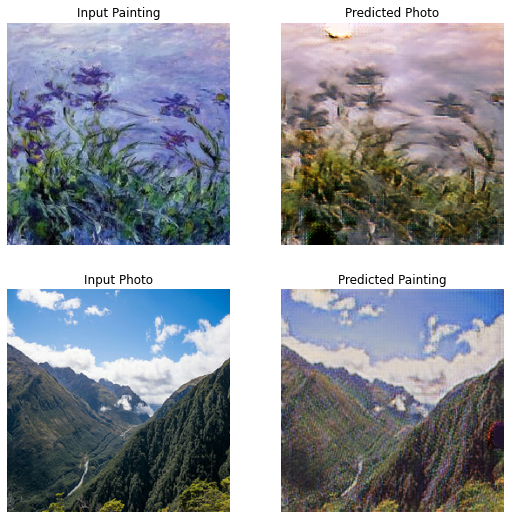

2022-09-22 19:49:22.214200: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Saving checkpoint for epoch 30 at ./ckpt/generator/ckpt-6
Time taken for epoch 30 is 425.2748739719391 sec



In [18]:
EPOCHS=30


for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_monet, train_photo)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n += 1
        clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
        generate_images(generator_g, generator_f, sample_monet, sample_photo)
        #generate_images(generator_f,sample_photo)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Here is a sample of 10 photos and 10 paintings ran through each generator. I would say that the predicted paintings are more convincing than the predicted photos, although it can vary from image to image.

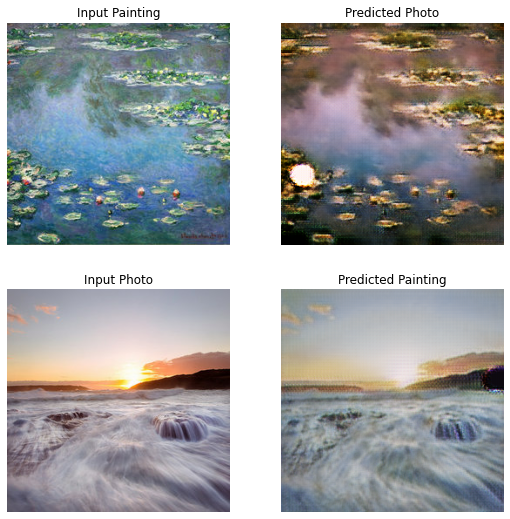

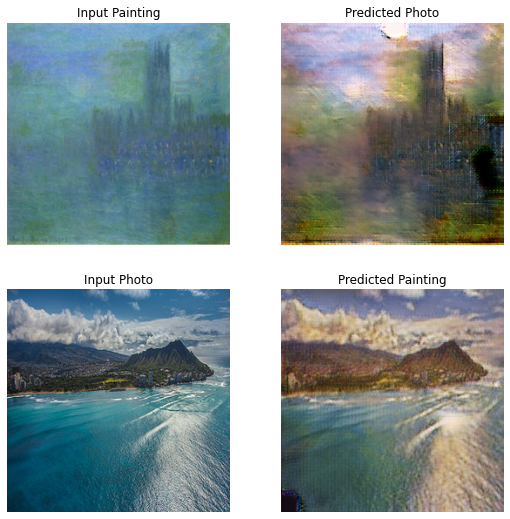

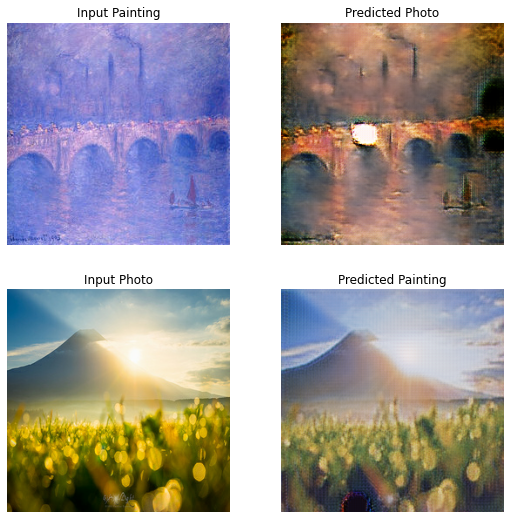

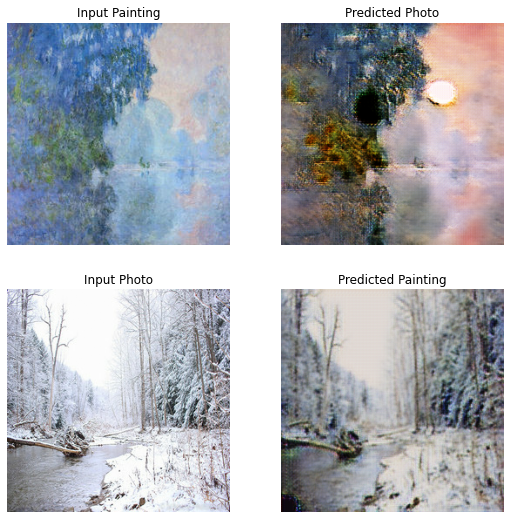

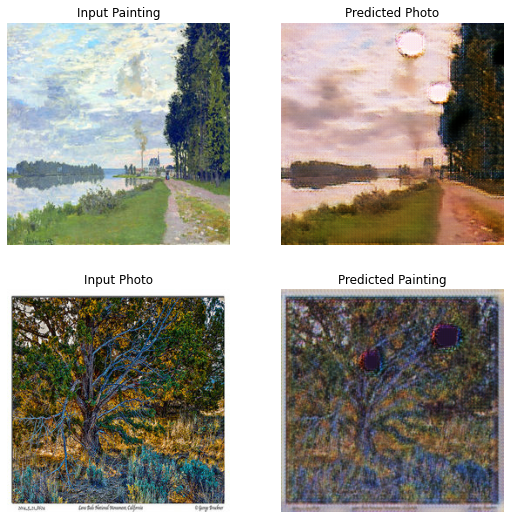

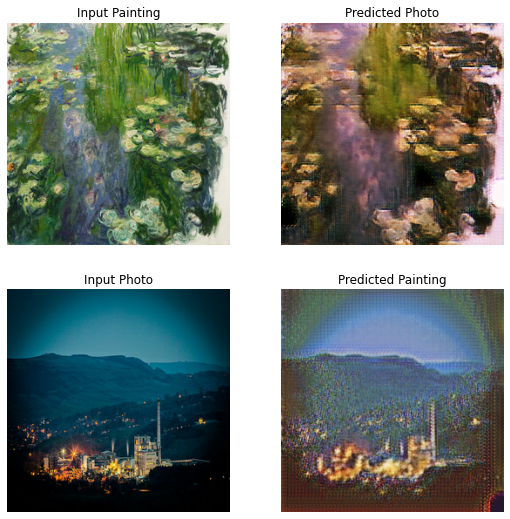

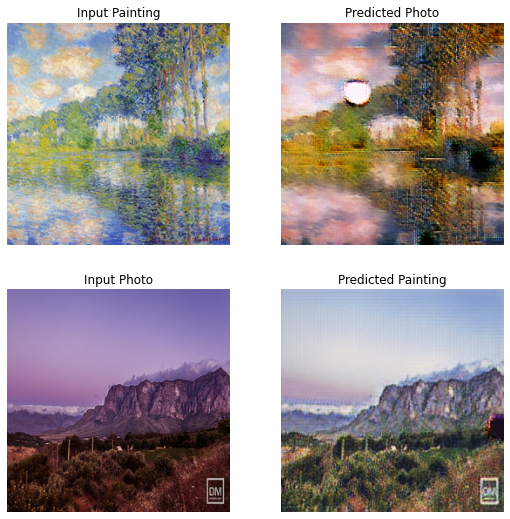

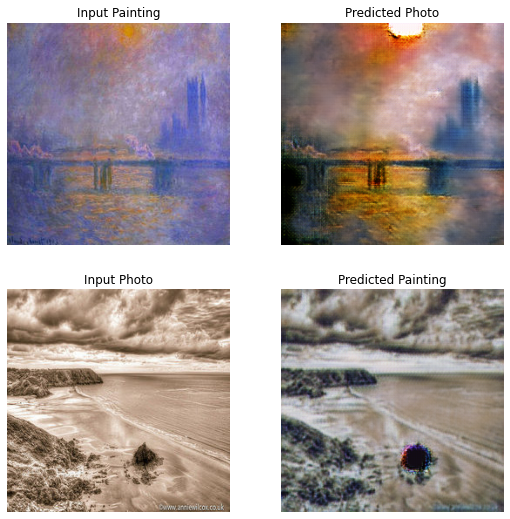

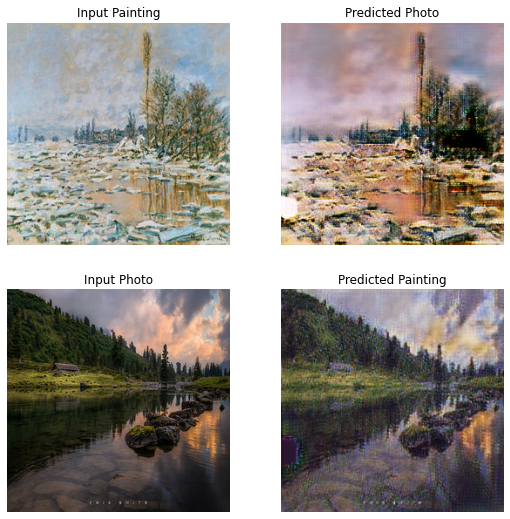

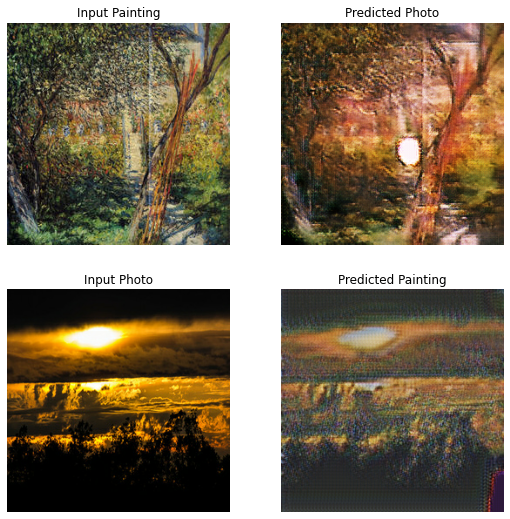

In [19]:
tvg = random.sample(list(test_monet),10)
tp = random.sample(list(test_photo),10)
for i in range(10):
    generate_images(generator_g,generator_f, tvg[i],tp[i])

## Processing and saving the generated paintings

For the Kaggle competition, I now have to generate 7000 paintings from real photos. These photos have to be preprocessed to ensure that their size is (256,256,3) and that each value is in the range [-1, 1] for the tanh activation function. They are then saved in the output file. The last cell erases the checkpoints and generates the zip file as the competition only accepts in images.zip as output. If it wasn't for the competition, you wouldn't have to delete the checkpoints as they can be useful.

In [20]:
def preprocess_custom_image(image):
    image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

In [21]:
def preprocess_and_predict_in_dir(model, dir_name):
    if os. path. isdir('./outputs'):
        shutil.rmtree('./outputs')
    b = 0
    os.makedirs('./outputs')
    for a in os.listdir(dir_name):
        image_to_be_read = dir_name + "/" + a
        img = plt.imread(image_to_be_read)
        preprocessed_image = preprocess_custom_image(img)
        preprocessed_image = tf.cast(preprocessed_image, dtype = tf.float32)
        preprocessed_image = (preprocessed_image/127.5) - 1
        preprocessed_image = preprocessed_image[tf.newaxis, ...]
        prediction = model(preprocessed_image)
        generated_img = keras.preprocessing.image.array_to_img(prediction[0])
        generated_img.save(f"./outputs/g{a}")
        b += 1
        if (b) % 1000 == 0:
            print ('{} images processed and saved'.format(b))

In [22]:
preprocess_and_predict_in_dir(generator_f, "../input/gan-getting-started/photo_jpg")

1000 images processed and saved
2000 images processed and saved
3000 images processed and saved
4000 images processed and saved
5000 images processed and saved
6000 images processed and saved
7000 images processed and saved


In [23]:
shutil.make_archive('./images', 'zip', './outputs')
shutil.rmtree('./outputs')
if os.path.isdir('./ckpt/generator'):
    shutil.rmtree('./ckpt')
if os.path.isfile('./images.zip'):
    print ('The generated images were compressed and saved as images.zip')

The generated images were compressed and saved as images.zip


# Conclusion

Through this project, I created a DCGAN model that is able to generate a fake Monet painting from a photo and a fake photo from a real Monet painting. By looking at the output files, I find that the fake photos aren't really convincing. On the other hand, some of the fake Monet paintings are quite convincing even though a human eye could tell a lot of them apart. After running and submitting my model to the Kaggle competition multiple times, I improved my model from a 217 accuracy to a 70 according to their grading method. The leaderboard shows that a good score would be 44 or less.I was limited by the computational power of Kaggle as I had to keep a relatively small batch_size and a low number of epochs to fit in the time training limit. I might try to tweak my model in the future to see if I can further improve my score. To avoid saturating the GPU, I would have to split the batch size and add steps in each epoch. I also noticed that increasing the batch size reduces the time taken for each epoch to run, so if I manage to increase batch size, I could also increase epochs which would further improve my model, although I should be careful to avoid overfitting. I could also change the generator and discriminator models but I think it's better to go with successful existing models. Overall, the difficulty of this project forced me to have a deeper understanding of DCGAN models and their implementation. I had a good time.

## References

[1] https://python.plainenglish.io/cycle-gans-generating-paintings-of-my-campus-in-van-goghs-style-9d578b11edf6  
[2] https://arxiv.org/pdf/1703.10593v7.pdf  
[3] https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d  
[4] https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/  
[5] https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/  
[6] https://www.nomidl.com/deep-learning/difference-between-leaky-relu-and-relu-activation-function/  
[7] https://www.baeldung.com/cs/sigmoid-vs-tanh-functions  
[8] https://www.baeldung.com/cs/instance-vs-batch-normalization 